# Spectral plotter

<div>
    When using this program, you need to make sure your data is inserted correctly. <br/> Make sure you have a <b>data</b> folder in the same directory as this notebook.
</div>
<img src="files/directoryView.png"/>
<div>
    Inside the data folder you need to create a new folder for the star you want to analyse.
</div>
<img src="files/dataView.png"/>
<div>
    In the folder for each star you would want to have the following data structure:
    <ul>
        <li>Directly inside the folder all the .fit files containing the spectra (preferrably an odd amount)</li>
        <li>A <b>dark</b> folder containing all the dark frames, which would be substracted from the averaged spectral image</li>
        <li>A <b>lamp</b> folder containing an image of the lamp used for calibration.</li>
    </ul>
    NOTE: The <b>results</b> folder should be created automatically.
</div>
<img src="files/folderView.png"/>

When executing the program only write in the name of the folder(in this case <b>'28Tau'</b>) and do not worry for the names of the .fit files inside the directory, they will be found automatically.

In [1]:
#Input star(directory) name
star_name = 'gammaCas'

In [2]:
# Prerequisites
from astropy.io import fits 
import glob
import numpy as np 
import matplotlib.pyplot as plt 
import math
import fits_reducer as fr
import lamp_calibrator as calibrator
import graph_helper
%matplotlib inline 

fr.create_reduced(star_name)

In [3]:
#Prerequisites for editing
input_file = 'data/' + star_name + '/results/' + star_name + '.fit'
# Range of y in which all of the signal is contained
rangelow = 560
rangeup = 610
# Upper bound from which pixels will be removed
cosm_filt = 110000

#lamp wavelengths - requires manual search for the wavelengths of the emission lines
line_lambda = [
    6598.95,
    6532.88,
    6506.30
]

lamp_file = glob.glob('data/' + star_name + '/lamp/*.fit')[0]
otpt_file = 'data/' + star_name + '/results/' + star_name + '.png'
max_otpt = 300
spectrum_y = 580
step_size = 3

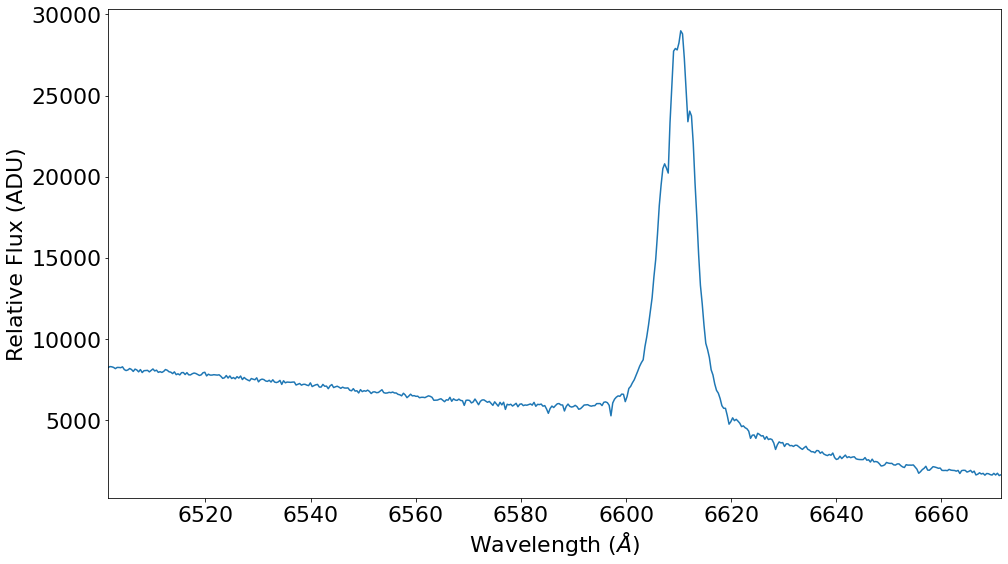

In [5]:
# Get the equation for the x-wavelength dependency
get_wavelength = calibrator.get_equation_from_lamp(lamp_file, line_lambda, spectrum_y)

# Loading input file
datahdu = fits.open(input_file) 
data, hdr = datahdu[0].data, datahdu[0].header

# Initialising axes
y = range(hdr['NAXIS1'])

# Summing all 'good' pixels in a column
# (ones that are not cosmics or burnt out)
xdata = np.sum(data[rangelow:rangeup,:], axis=0)

# Smoothen the graph
(avg_list, size) = graph_helper.smoothen_graph(xdata, step_size)
        
# Gets the range of wavelengths and cuts the first and last 5 data points
x = np.linspace(get_wavelength(step_size*size-5),get_wavelength(5),num = size-10)
# Reverse the dataset
data = avg_list[5:size-5]
np.flip(data)

# Plot graph
plt.figure(figsize=(16,9))
plt.rcParams.update({'font.size':22})
plt.plot(x,data)
plt.xlabel(r"Wavelength ($\AA$)")
plt.ylabel("Relative Flux (ADU)")
plt.xlim(get_wavelength(step_size*size-5),get_wavelength(5))
plt.savefig(otpt_file)